In [143]:
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean
from rlhfutils.rl_utils import get_synth_rewards
from tqdm import tqdm
from datasets import Dataset, concatenate_datasets

In [144]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:
# tlog = pd.read_json("../../outputs/bagofwords/dynarmlogs/expbow50_updatereprod_fix.jsonl", orient='records', lines=True)
# tlog = pd.read_json("../../active-rlhf/outputs/results/dynarmlogs/math/tiny_rm_rand8repeasy1v2.jsonl", orient='records', lines=True, nrows=64000)
tlog = pd.read_json("../../active-rlhf/outputs/results/rollouts/math/ppo_goldb8easy2fix.jsonl", orient='records', lines=True, nrows=64000)

# tlog = pd.read_json("../../activereprod/active-rlhf/outputs/results/dynarmlogs/math/u/prasanns/research/active-rlhf/outputs/models/math/tiny_rm_rand_subsamp_onlymathreprod3.jsonl", orient='records', lines=True)
# tlog = pd.read_json("../outputs/results/dynarmlogs/.jsonl", orient='records', lines=True)
tmp = tlog
if 'golds' not in tmp.keys():
    tmp['golds'] = tmp['rewards']

tmp = tmp.dropna(subset='golds')

In [177]:
# tmp.iloc[-1]['texts']

In [178]:
a = [1,2,3]
b = [1]
for i in zip(a, b):
    print(i)

(1, 1)


In [179]:
# tmp.iloc[-1]['texts']

In [180]:
# tmp['texts'][3103]

In [181]:
rat = 0
ngs = []
accs = []
sind = 0
for ind, row in tmp.iloc[sind:].iterrows():
    # row['golds'] = get_synth_rewards(row['texts'], 'bagofwords')
    if len(row['golds'])==0:
        continue
    if row['golds'][0]==row['golds'][1]:
            continue
    ngs.append(row['golds'])
    if ((row['rewards'][0]>row['rewards'][1])!=(row['golds'][0]>row['golds'][1])):
        rat+=1
        accs.append(0)
    else:
        accs.append(1)
#tmp['golds'] = ngs
print(rat/len(ngs))

0.0


In [182]:
tot, corr = 0, 0
vals = []
interv = 200
for j in range(0, len(accs), interv):
    vals.append(mean(accs[j:j+interv]))
    # # check heuristic accuracy
    # for i, row in tmp.iloc[j:j+interv].iterrows():
    #     # if abs(row['rewards'][0]-row['rewards'][1])>row['thresh']:
    #     if row['golds'][0]==row['golds'][1]:
    #         continue
    #     tot = tot+1
    #     corr += 1 if ((row['rewards'][0]>row['rewards'][1])==(row['golds'][0]>row['golds'][1])) else 0
    # vals.append(corr/tot)

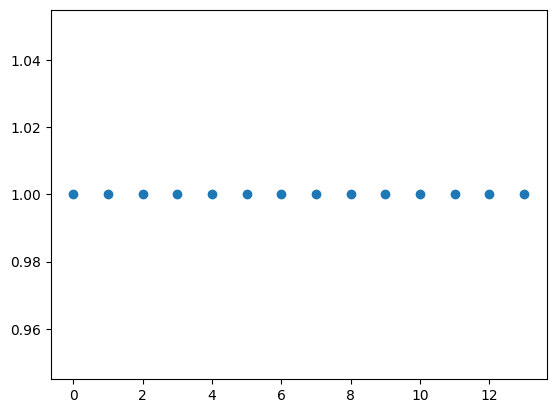

In [183]:
plt.scatter(range(len(vals)), vals)

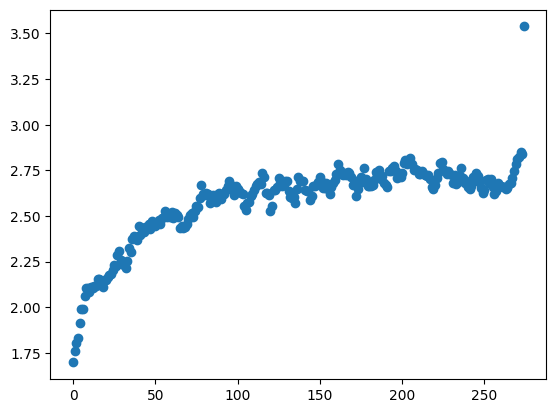

In [184]:
means = [mean(m) for m in ngs]
# means = [mean(m) for m in tmp['rewards']]

interv = 10
mbins = [mean(means[i:i+50]) for i in range(0, len(means), interv)]
plt.scatter(range(len(mbins)), mbins)

In [175]:
tmp

,texts,rewards,golds,call
0,[Question: ((3 - 5) * 3) = \n\nAnswer: ((-4 *...,"[-0.09033203125, 0.416015625]","[0.833333333333333, 0.555555555555555]","[1, 1]"
1,[Question: ((8 - 5) - 8) = \n\nAnswer: ((1 - ...,"[0.65234375, -0.076171875]","[1.574074074074074, 1.074074074074074]","[1, 1]"
2,[Question: ((9 + 3) * 6) = \n\nAnswer: ((15 *...,"[-0.076171875, -0.072265625]","[1.25, 1.5]","[1, 1]"
3,[Question: ((6 + 9) * 7) = \n\nAnswer: ((17 *...,"[-0.072265625, -0.068359375]","[1.6071428571428572, 1.5]","[1, 1]"
4,[Question: ((7 + 3) - 8) = \n\nAnswer: ((10 -...,"[-0.08447265625, -0.06787109375]","[1.5, 2.1428571428571432]","[1, 1]"
...,...,...,...,...
48891,[Question: ((5 + 9) + 7) = \n\nAnswer: (13 + ...,"[-0.037841796875, 0.06689453125]","[2.083333333333333, 2.5]","[3056, 3056]"
48892,[Question: ((8 * 8) - 1) = \n\nAnswer: (24 - ...,"[0.361328125, 0.00579833984375]","[2.083333333333333, 1.666666666666667]","[3056, 3056]"
48893,[Question: ((3 + 7) + 9) = \n\nAnswer: (10 + ...,"[-0.03466796875, 0.02392578125]","[2.5, 3.333333333333334]","[3056, 3056]"
48894,[Question: ((6 * 1) * 1) = \n\nAnswer: (7 * 1...,"[-0.04736328125, -0.04052734375]","[2.0, 2.5]","[3056, 3056]"


In [50]:
mean(means[-20:])

2.001967592592593

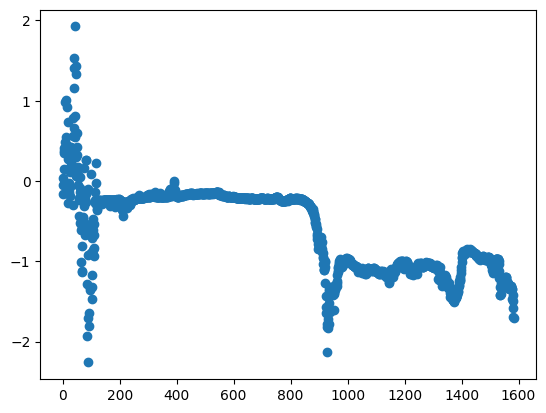

In [42]:
means = [mean(m) for m in tmp['golds']]
plt.scatter(range(len(means)), means)